# Exploratory Data Analysis (EDA)

## Imports

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


# sklearn
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# scipy
import scipy.stats as scs

# for min_max scaling
from mlxtend.preprocessing import minmax_scaling

# for Box-Cox Transformation
from scipy import stats

In [113]:
dataset = pd.read_csv("DATA/dataset.csv", sep=',')
dataset

,Unnamed: 0,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,2072,-119.84,36.77,6.0,1853.0,473.0,1397.0,417.0,1.4817,72000.0,INLAND
1,10600,-117.80,33.68,8.0,2032.0,349.0,862.0,340.0,6.9133,274100.0,<1H OCEAN
2,2494,-120.19,36.60,25.0,875.0,214.0,931.0,214.0,1.5536,58300.0,INLAND
3,4284,-118.32,34.10,31.0,622.0,229.0,597.0,227.0,1.5284,200000.0,<1H OCEAN
4,16541,-121.23,37.79,21.0,1922.0,373.0,1130.0,372.0,4.0815,117900.0,INLAND
...,...,...,...,...,...,...,...,...,...,...,...
16507,1099,-121.90,39.59,20.0,1465.0,278.0,745.0,250.0,3.0625,93800.0,INLAND
16508,18898,-122.25,38.11,49.0,2365.0,504.0,1131.0,458.0,2.6133,103100.0,NEAR BAY
16509,11798,-121.22,38.92,19.0,2531.0,461.0,1206.0,429.0,4.4958,192600.0,INLAND
16510,6637,-118.14,34.16,39.0,2776.0,840.0,2546.0,773.0,2.5750,153500.0,<1H OCEAN


## Analyse du dataset

In [114]:
# informations dataset (numbers of rows, columns)
dataset.shape

(16512, 11)

In [115]:
# check Dtype
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          16512 non-null  int64  
 1   longitude           16512 non-null  float64
 2   latitude            16512 non-null  float64
 3   housing_median_age  16512 non-null  float64
 4   total_rooms         16512 non-null  float64
 5   total_bedrooms      16336 non-null  float64
 6   population          16512 non-null  float64
 7   households          16512 non-null  float64
 8   median_income       16512 non-null  float64
 9   median_house_value  16512 non-null  float64
 10  ocean_proximity     16512 non-null  object 
dtypes: float64(9), int64(1), object(1)
memory usage: 1.4+ MB


In [116]:
#Fonction pour regarder mes valeurs manquantes
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
        return mz_table

In [117]:
missing_zero_values_table(dataset)

Your selected dataframe has 11 columns and 16512 Rows.
There are 1 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
total_bedrooms,0,176,1.1,176,1.1,float64


Nous avons uniquement des valeurs manquantes sur total_bedrooms.

176 lignes qui répresentent 1,1 % de notre dataset.

Il n' y pas de valeur 0 non plus dans notre dataset.

Au vue du pourcentage je pourrais supprimer les données manquantes , ou si la feature est trop significatif envisager une imputation.

In [118]:
# check for zeros in all columns 
dataset[dataset == 0].count()

Unnamed: 0            1
longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [119]:
# max & min values on total_bedrooms
print(dataset['total_bedrooms'].max())
print(dataset['total_bedrooms'].min())

6445.0
2.0


In [120]:
# Fonction qui permet de tester si une cle est fiable #

def testerCle(df, colonnes):
    """Fonction qui prend en arguments un dataframe et les colonnes qui composent la clé primaire à tester."""

    # On compare la taille du dataframe avant et après dédoublonnage 
    if df.size == df.drop_duplicates(colonnes).size :
        print("La clé n'est pas présente plusieurs fois dans le dataframe.")
        print("Elle peut donc être utilisée comme clé primaire.".format(colonnes))
    else :
        print("La clé est présente plusieurs fois dans le dataframe.")
        print("Elle ne peut donc pas être utilisée comme clé primaire.".format(colonnes))
    
    # On renvoie également le comptage
    print("Le dataframe est de la forme : " + str(df.shape) + " (lignes, colonnes)")

In [121]:
testerCle(dataset,['Unnamed: 0'])

La clé n'est pas présente plusieurs fois dans le dataframe.
Elle peut donc être utilisée comme clé primaire.
Le dataframe est de la forme : (16512, 11) (lignes, colonnes)


Je renomme Unnamed en ID , et je verrais par la suite si je le garde ou si je le drop et me base sur l'index.

In [122]:
dataset.rename(columns = {'Unnamed: 0':'ID'}, inplace = True)
dataset

,ID,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,2072,-119.84,36.77,6.0,1853.0,473.0,1397.0,417.0,1.4817,72000.0,INLAND
1,10600,-117.80,33.68,8.0,2032.0,349.0,862.0,340.0,6.9133,274100.0,<1H OCEAN
2,2494,-120.19,36.60,25.0,875.0,214.0,931.0,214.0,1.5536,58300.0,INLAND
3,4284,-118.32,34.10,31.0,622.0,229.0,597.0,227.0,1.5284,200000.0,<1H OCEAN
4,16541,-121.23,37.79,21.0,1922.0,373.0,1130.0,372.0,4.0815,117900.0,INLAND
...,...,...,...,...,...,...,...,...,...,...,...
16507,1099,-121.90,39.59,20.0,1465.0,278.0,745.0,250.0,3.0625,93800.0,INLAND
16508,18898,-122.25,38.11,49.0,2365.0,504.0,1131.0,458.0,2.6133,103100.0,NEAR BAY
16509,11798,-121.22,38.92,19.0,2531.0,461.0,1206.0,429.0,4.4958,192600.0,INLAND
16510,6637,-118.14,34.16,39.0,2776.0,840.0,2546.0,773.0,2.5750,153500.0,<1H OCEAN


## Nettoyage des données 

Au vue du temps allouer pour ce projet , je decide de faire de l'imputation de mes valeurs manquantes dans total_bedrooms.

Même si cela représente que 1% de mes données , je vais comparer les différentes méthodes d'imputation et choisir celle qui me semble la meilleure.

Cela me permet de m'entrainer sur l'imputation 

### Imputation des valeurs manquantes 

In [123]:
dataset['total_bedrooms'].isnull().sum()

176

In [124]:
valeur_manquantes= dataset.loc[np.isnan(dataset['total_bedrooms']),'total_bedrooms']
valeur_manquantes

33      NaN
171     NaN
178     NaN
179     NaN
259     NaN
         ..
16002   NaN
16089   NaN
16214   NaN
16228   NaN
16323   NaN
Name: total_bedrooms, Length: 176, dtype: float64

#### Imputation moyenne

In [125]:
# Mean Imputation

df_mean = dataset.copy()
mean_imputer = SimpleImputer(strategy='mean')
df_mean['total_bedrooms'] = mean_imputer.fit_transform(df_mean['total_bedrooms'].values.reshape(-1,1))

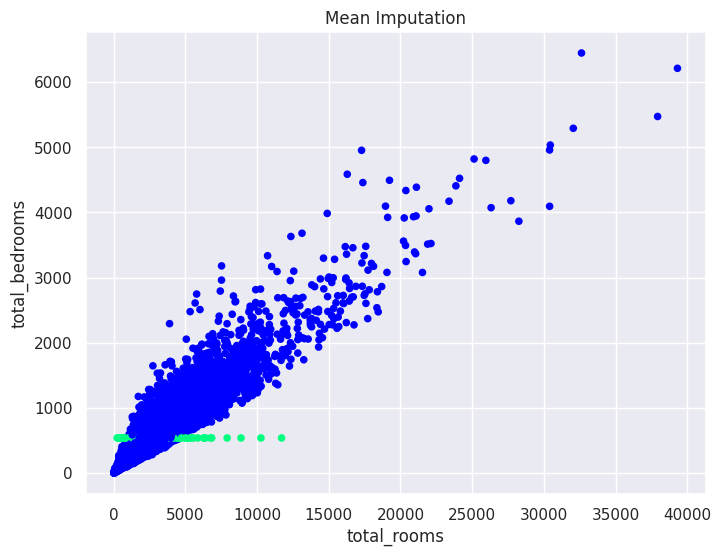

In [126]:
# Scatter plot
fig = plt.Figure()
null_values = dataset['total_bedrooms'].isnull()
fig = df_mean.plot(x='total_rooms', y='total_bedrooms', kind='scatter', c=null_values, cmap='winter', title='Mean Imputation', colorbar=False)

#### Imputation modale

In [127]:
# Mode Imputation

df_mode = dataset.copy()
mode_imputer = SimpleImputer(strategy='most_frequent')
df_mode['total_bedrooms'] = mode_imputer.fit_transform(df_mode['total_bedrooms'].values.reshape(-1,1))

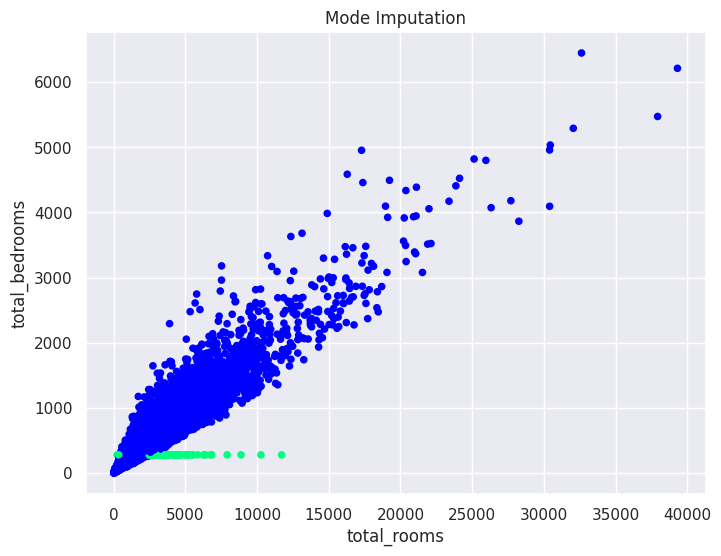

In [128]:
# Scatter plot

fig = plt.Figure()
null_values = dataset['total_bedrooms'].isnull()
fig = df_mode.plot(x='total_rooms', y='total_bedrooms', kind='scatter', c=null_values, cmap='winter', title='Mode Imputation', colorbar=False)

#### Imputation K-plus proche voisin (KNN)

In [129]:
#Define a subset of the dataset
df_knn = dataset.filter(['housing_median_age','total_rooms','total_bedrooms','population','households','median_income','median_house_value'], axis=1).copy()

In [130]:
# Define scaler to set values between 0 and 1

scaler = MinMaxScaler(feature_range=(0, 1))
df_knn = pd.DataFrame(scaler.fit_transform(df_knn), columns = df_knn.columns)

j'ai filtré les données et j'utilise MinMaxScalerscikit-learn pour normaliser mes données numériques entre 0 et 1. 

Étant donné que KNNImputer est un algorithme basé sur la distance, la mise à l'échelle est une étape importante dans le pipeline.

In [131]:
# Define KNN imputer and fill missing values
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=df_knn.columns)

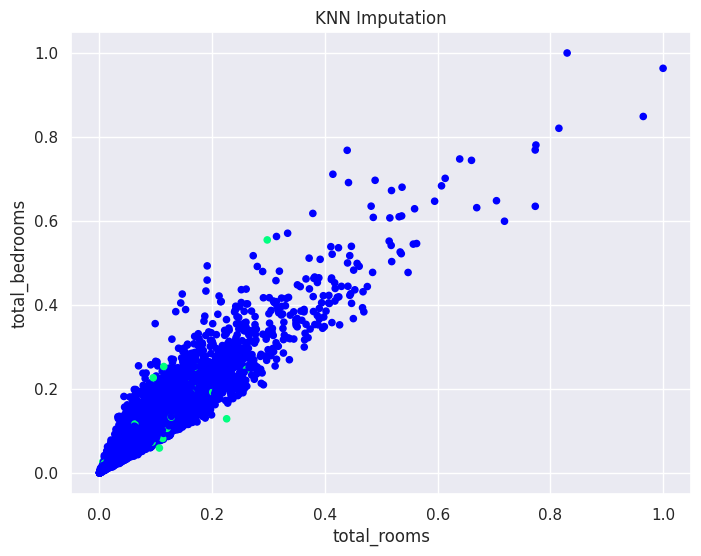

In [132]:

fig = plt.Figure()
null_values = dataset['total_bedrooms'].isnull() 
fig = df_knn_imputed.plot(x='total_rooms', y='total_bedrooms', kind='scatter', c=null_values, cmap='winter', title='KNN Imputation', colorbar=False)

#### Imputation multivariée par équation chaînée — MICE

In [133]:

# Imputing with MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model

df_mice = dataset.filter(['housing_median_age','total_rooms','total_bedrooms','population','households','median_income','median_house_value'], axis=1).copy()

# Define MICE Imputer and fill missing values
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')

df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)

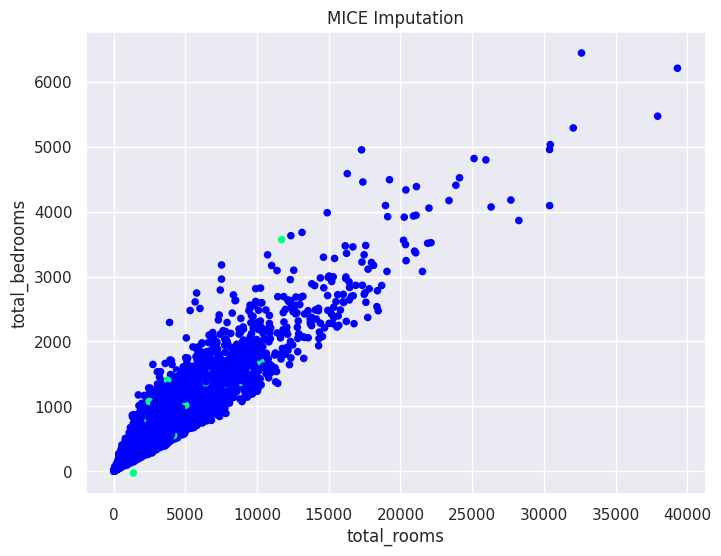

In [134]:

fig = plt.Figure()
null_values = dataset['total_bedrooms'].isnull() 
fig = df_mice_imputed.plot(x='total_rooms', y='total_bedrooms', kind='scatter', c=null_values, cmap='winter', title='MICE Imputation', colorbar=False)

### Conclusion et choix pour l'imputation 

Les techniques d'impoutation plus avancées, K-Nearest Neighbor Imputation (KNN) et Multivariate Imputation by Chained Equations (MICE) qui utilisent l'apprentissage automatique pour remplir les valeurs manquantes sont plus adaptés.

Je choisi d'imputer les valeurs manquantes avec la méthode KNN qui consiste à les prédire. 

L'imputation par le plus proche voisin est la plus efficace pour mes valeurs manquantes.

In [135]:
# replace missing values on total_bedrooms with KNN
knn_imputer = KNNImputer(n_neighbors=4, weights="uniform")
dataset['total_bedrooms'] = knn_imputer.fit_transform(dataset[['total_bedrooms']])

### Distribution

In [136]:
columns = ['housing_median_age','total_rooms','total_bedrooms',
               'population','households','median_income','median_house_value']

In [137]:
df = dataset.drop(['ID','ocean_proximity','latitude','longitude'], axis=1)
df

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,6.0,1853.0,473.0,1397.0,417.0,1.4817,72000.0
1,8.0,2032.0,349.0,862.0,340.0,6.9133,274100.0
2,25.0,875.0,214.0,931.0,214.0,1.5536,58300.0
3,31.0,622.0,229.0,597.0,227.0,1.5284,200000.0
4,21.0,1922.0,373.0,1130.0,372.0,4.0815,117900.0
...,...,...,...,...,...,...,...
16507,20.0,1465.0,278.0,745.0,250.0,3.0625,93800.0
16508,49.0,2365.0,504.0,1131.0,458.0,2.6133,103100.0
16509,19.0,2531.0,461.0,1206.0,429.0,4.4958,192600.0
16510,39.0,2776.0,840.0,2546.0,773.0,2.5750,153500.0


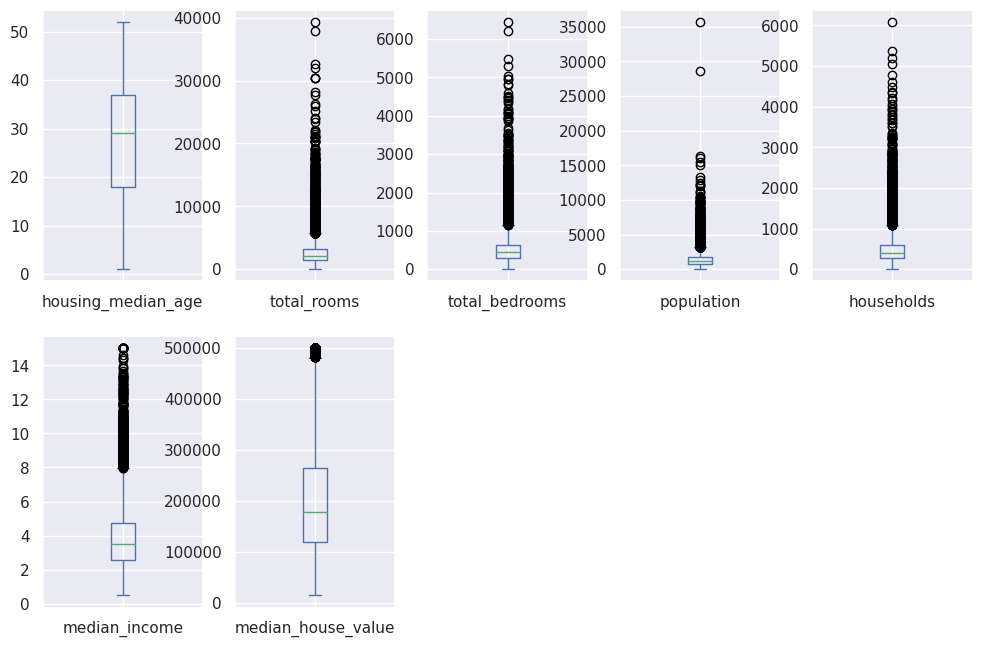

In [138]:
#individuel plot
df.plot(kind='box', subplots=True, layout=(3, 5), figsize=(12, 12));

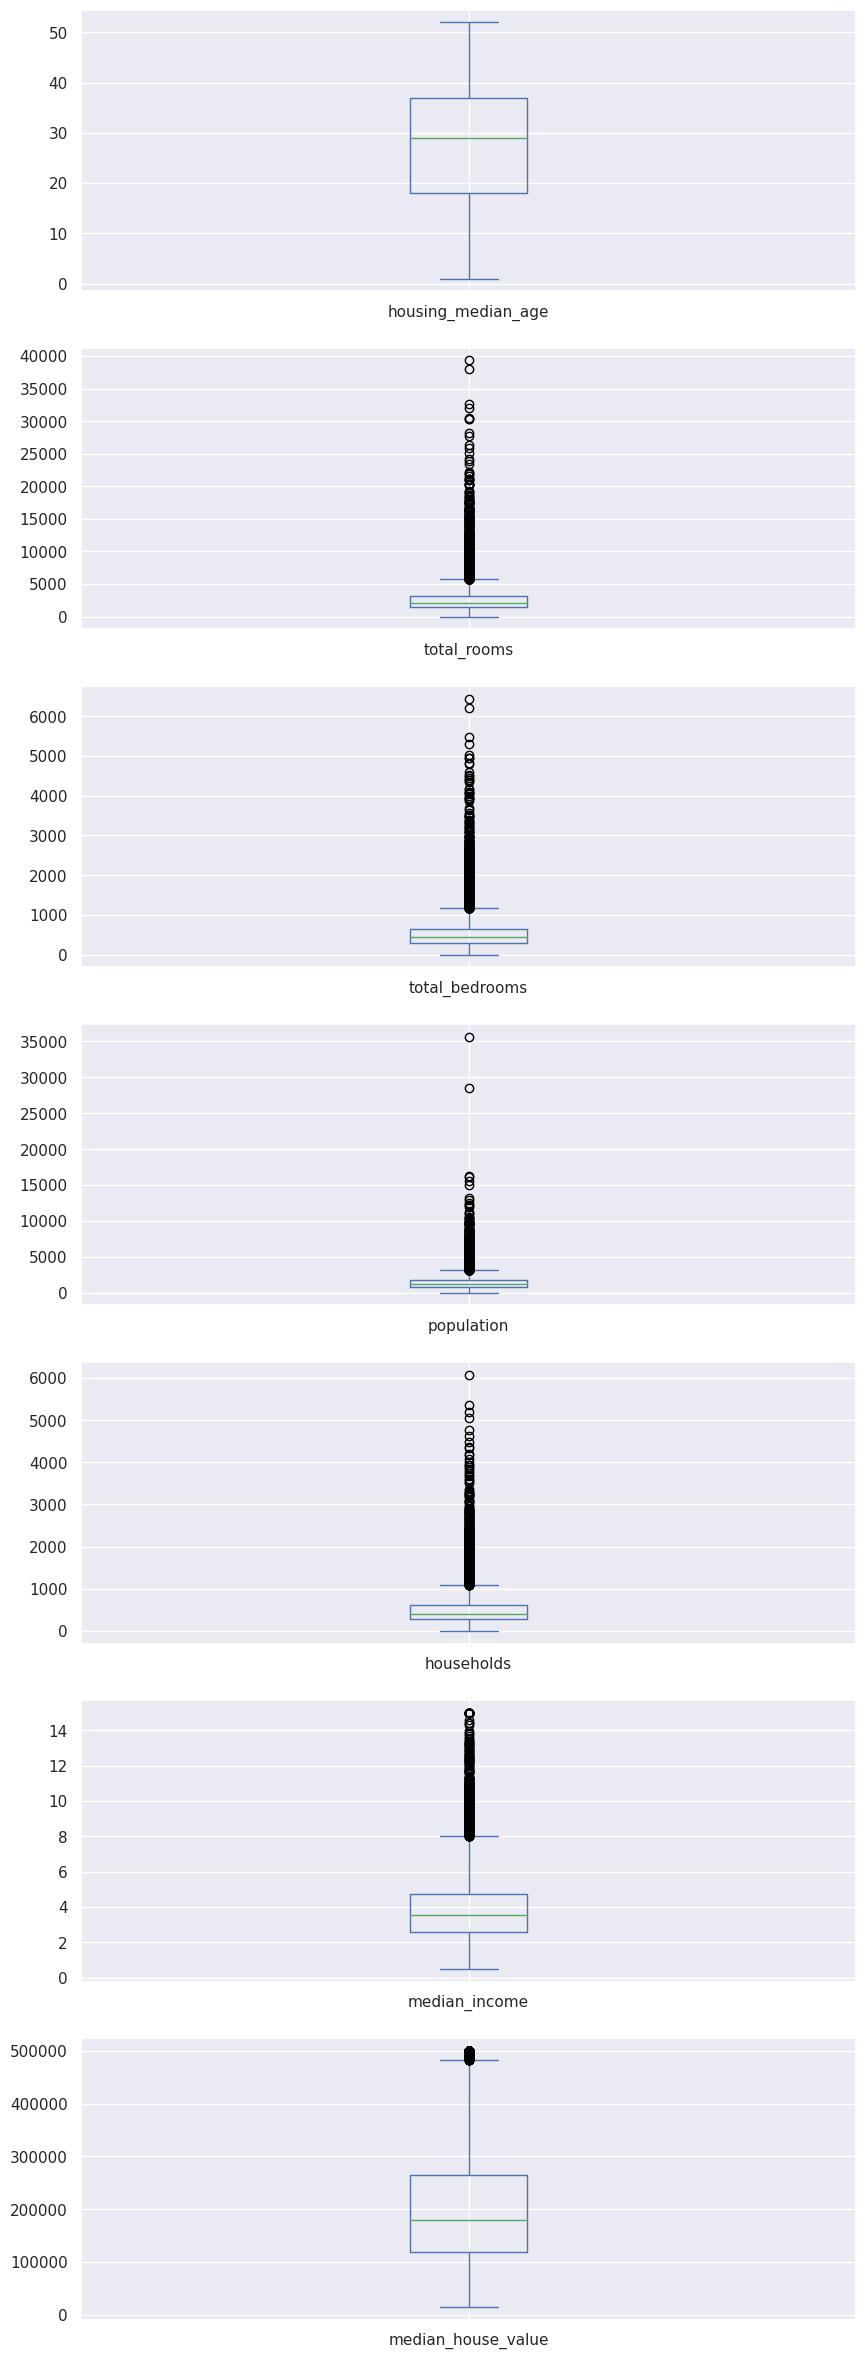

In [139]:
fig = plt.figure(figsize=(10, 30))
gs = gridspec.GridSpec(len(columns), 1)

for i, col in enumerate(columns):
    ax = fig.add_subplot(gs[i, 0])
    df[col].plot(kind='box', ax=ax)

In [140]:
col = np.array(dataset.drop(['ID','ocean_proximity','latitude','longitude'], axis=1).columns)

In [ ]:
# pip install mlxtend

In [142]:
# for i in col :
# # generate 1000 data points randomly drawn from an exponential distribution
#     original_data = dataset[i]

# # mix-max scale the data between 0 and 1
#     scaled_data = minmax_scaling(original_data, columns=[0])

#     # plot both together to compare
#     fig, ax = plt.subplots(1, 2, figsize=(15, 3))
#     sns.histplot(original_data, ax=ax[0], kde=True, legend=False)
#     ax[0].set_title("Original Data")
#     sns.histplot(scaled_data, ax=ax[1], kde=True, legend=False)
#     ax[1].set_title("Scaled data")
#     plt.show()

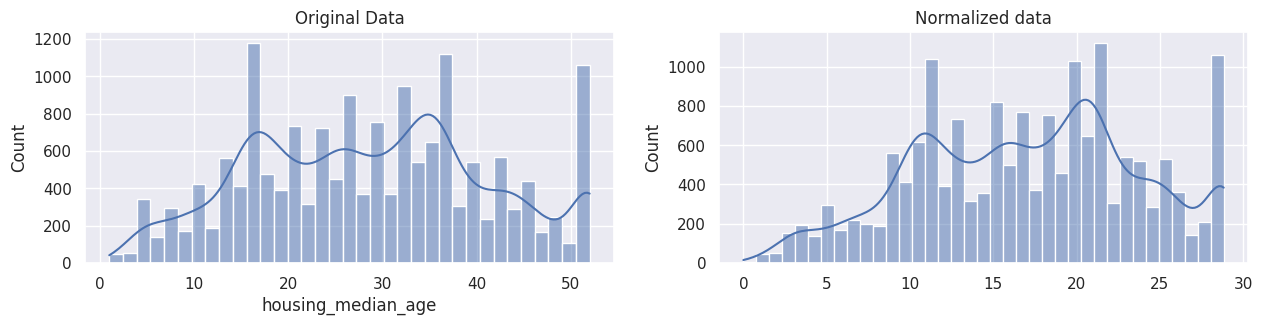

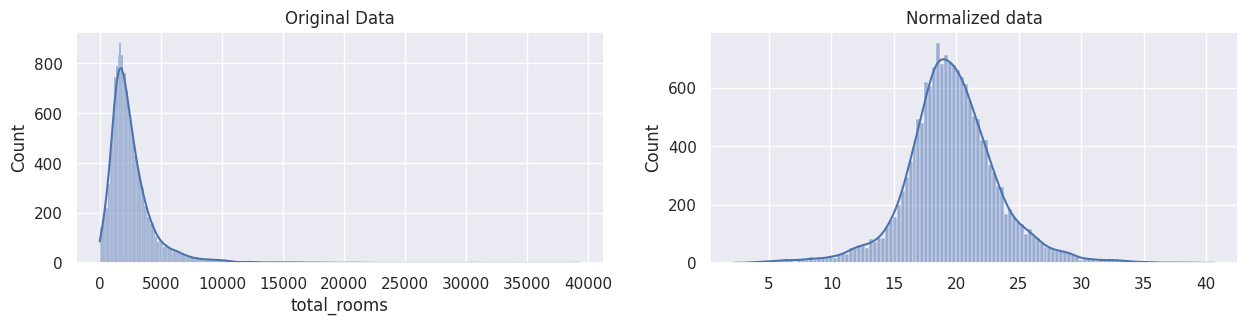

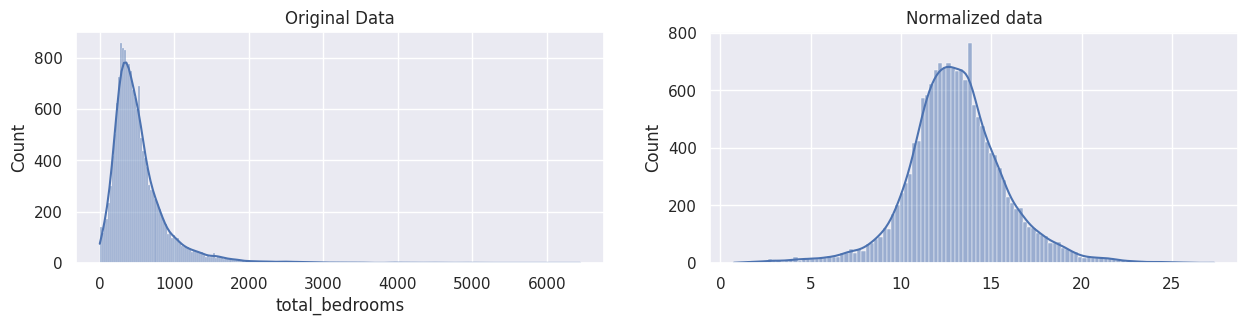

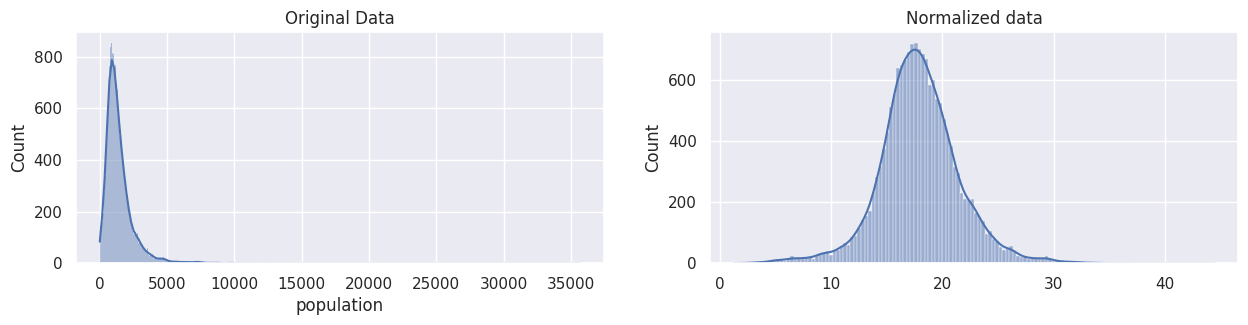

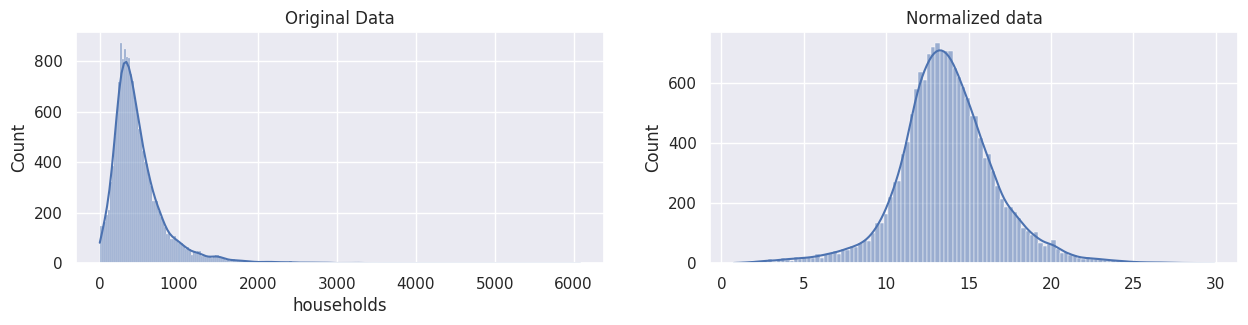

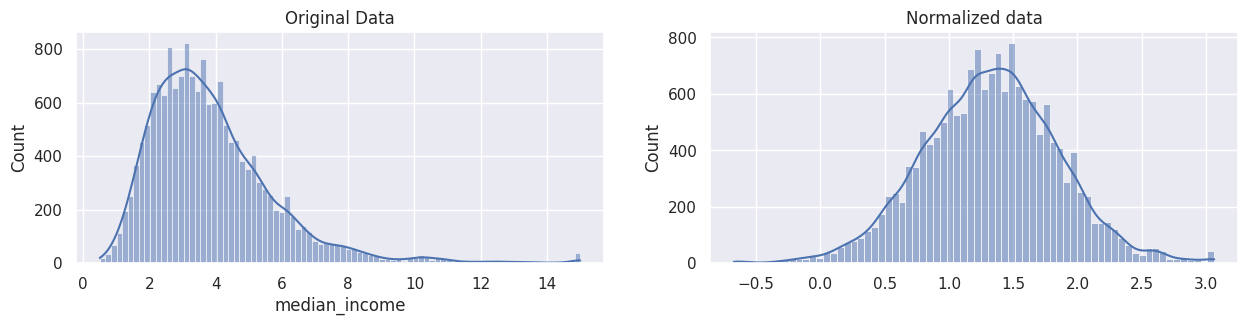

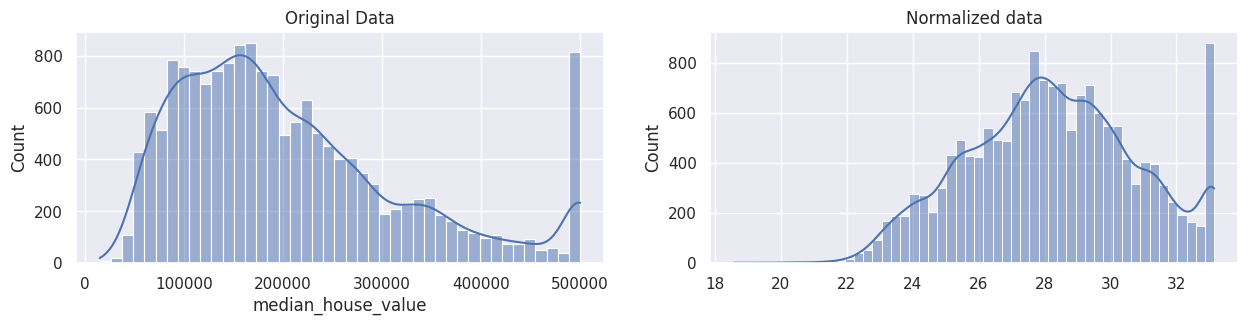

In [143]:
for i in col :
# generate 1000 data points randomly drawn from an exponential distribution
    original_data = dataset[i]

    # normalize the exponential data with boxcox
    normalized_data = stats.boxcox(original_data)

    # plot both together to compare
    fig, ax=plt.subplots(1, 2, figsize=(15, 3))
    sns.histplot(original_data, ax=ax[0], kde=True, legend=False)
    ax[0].set_title("Original Data")
    sns.histplot(normalized_data[0], ax=ax[1], kde=True, legend=False)
    ax[1].set_title("Normalized data")
    plt.show()

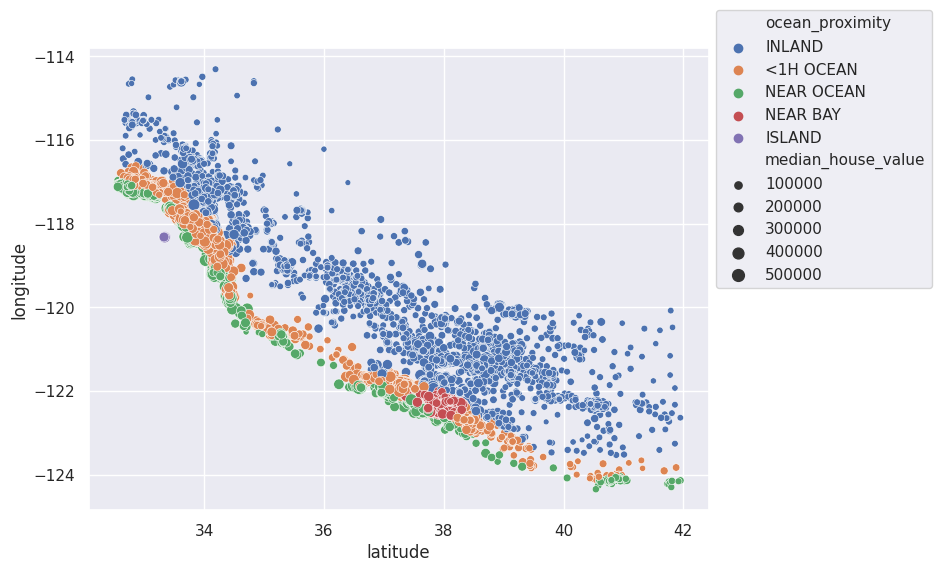

In [144]:
sns.set(style="darkgrid",rc={'figure.figsize':(8,6)}, palette = "deep")
nouveau= sns.scatterplot(y="longitude", x="latitude", data=dataset, hue=dataset['ocean_proximity'], size =dataset['median_house_value'] )
nouveau.legend(bbox_to_anchor=(1, 1.1), loc='upper left')

In [152]:
# sns.boxplot(data=df)

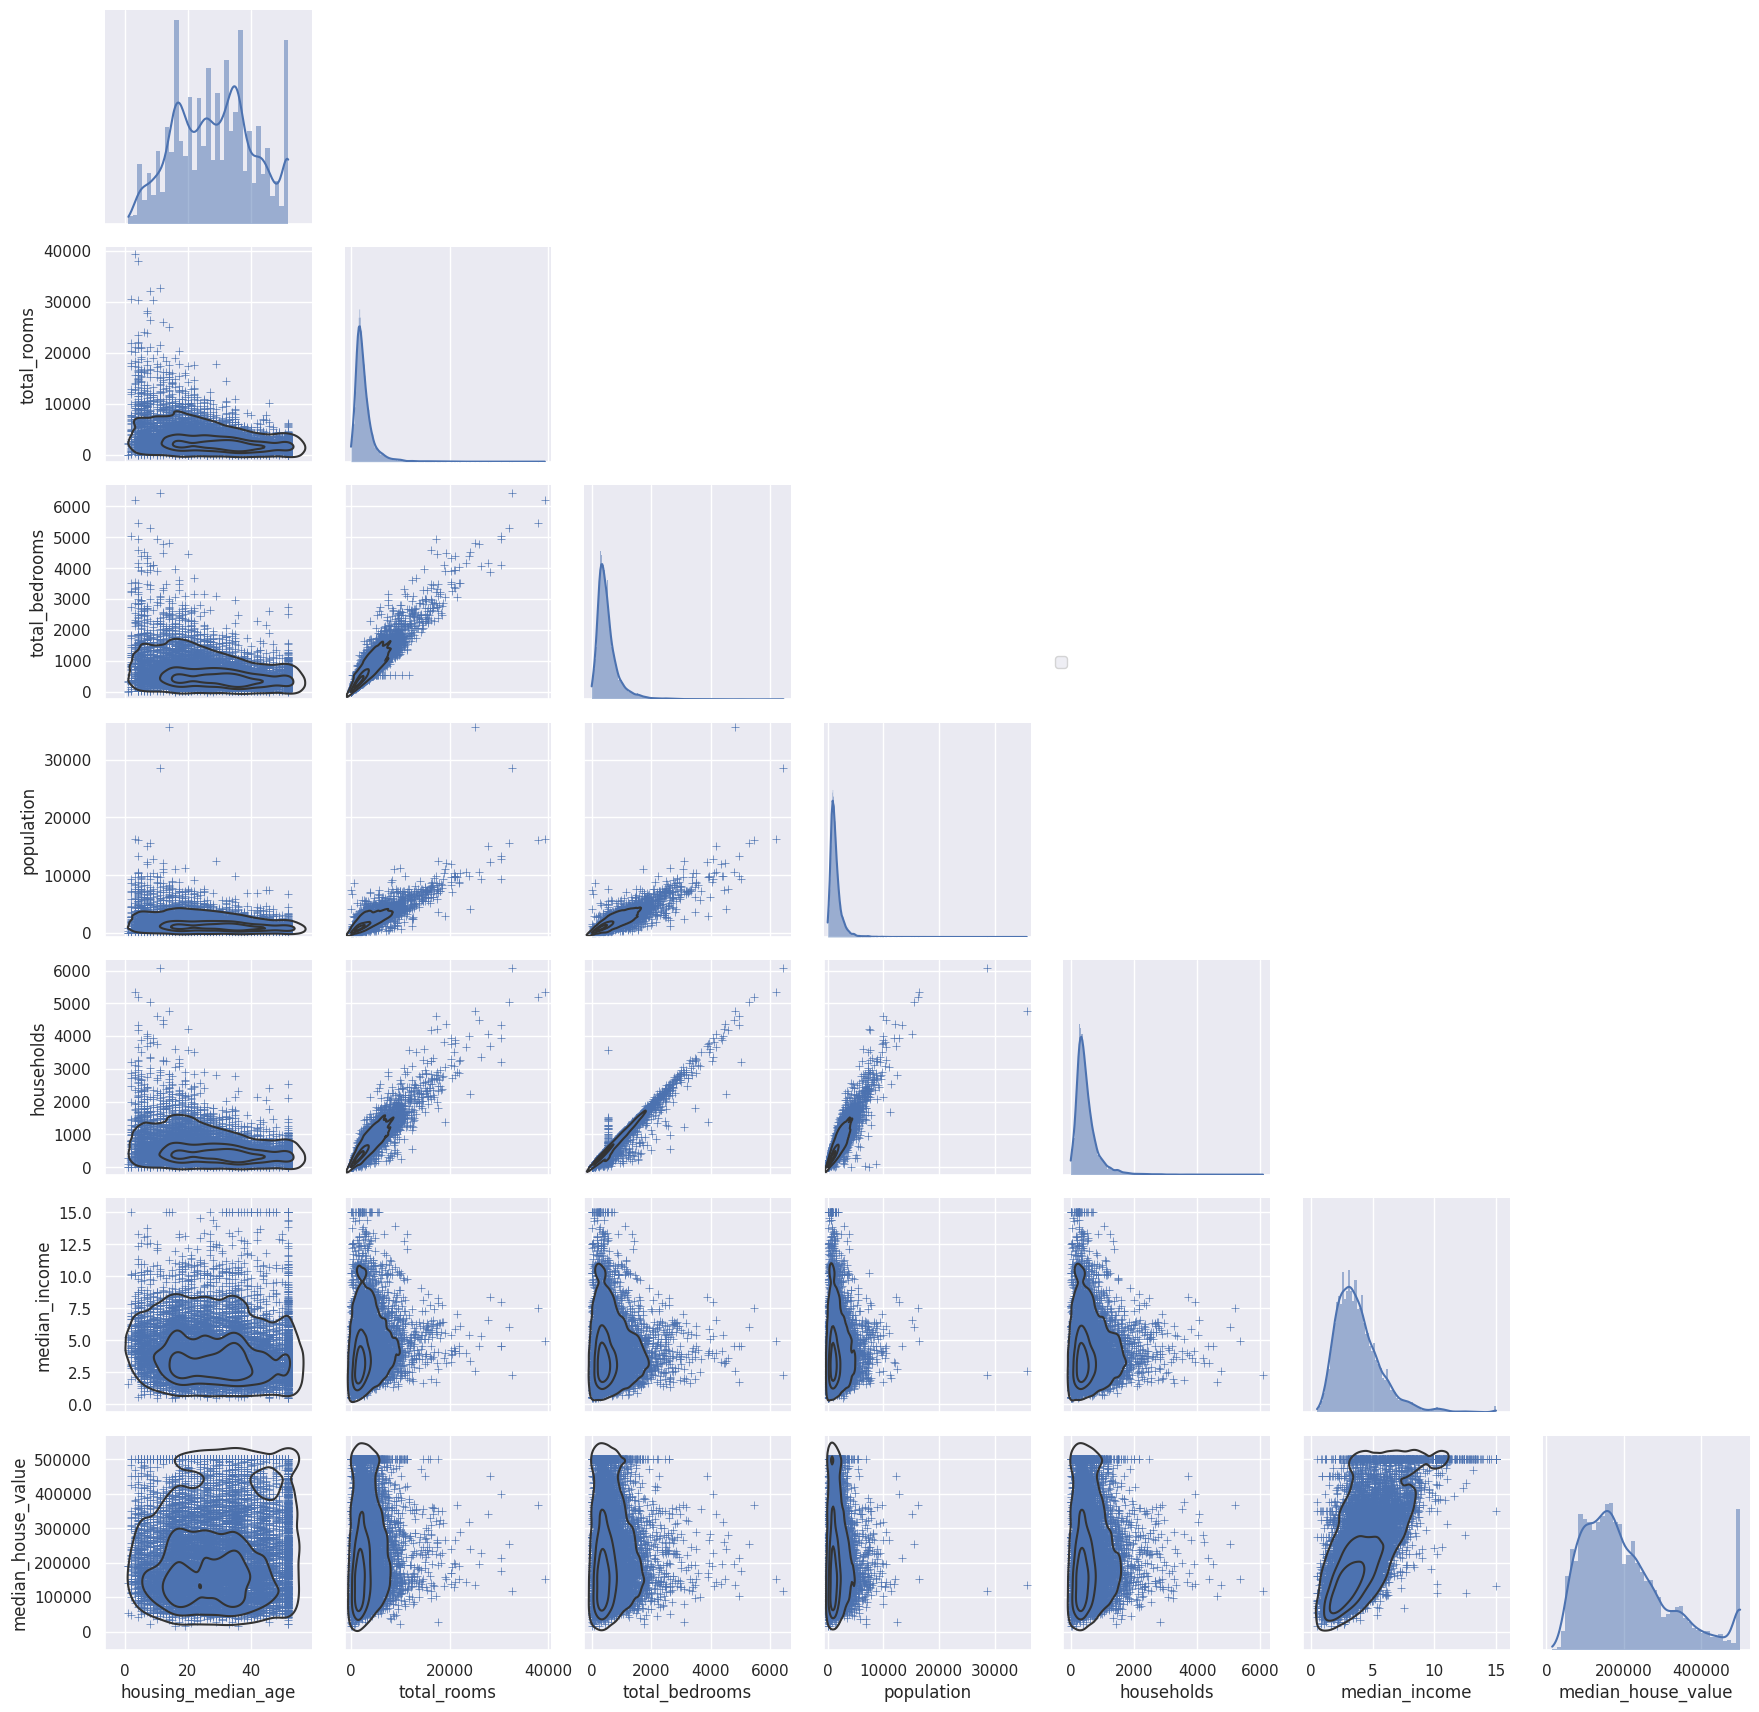

In [154]:
g = sns.PairGrid(data = df, corner = True)
g.map_lower(sns.kdeplot, hue = None, levels = 4, color = ".2")
g.map_lower(sns.scatterplot, marker = "+")
g.map_diag(sns.histplot, element = 'step', linewidth=0,kde=True)
g.add_legend(frameon=True)
g.legend.set_bbox_to_anchor((.61,.6))